# FP UOL 24 - Fake News Detection with BERT Based Transfer Learning and Fine-tuning Techniques

## Part I - Introduction & Setup

#### 1.1 Notes

--------------------------

**Usage notes:**
- The notebook is set up to run on Google Colab. The installs and imports are based on pre-installed google colab setup.
- It is recommended to run it with NVIDIA A100 GPU to handle the GPU RAM training requirements pre-sets you might be required to reduce certain parameters to reduce meet GPU RAM requirements for other GPUs
--------------------------

#### 1.2 Imports & Installs

All installs and imports are managed here

In [ ]:
#install if required - everything else is pre-installed when ran in google colab
!pip install -U tensorflow-text==2.15.0
!pip install nltk
!pip install keras-tuner -q

Import all relevant packages

In [ ]:
#imports
import gdown
import warnings
import math
from zipfile import ZipFile
import numpy as np
import pandas as pd
import re
import time
import nltk
from random import randint
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_non_alphanum
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from tensorflow import keras
import keras_tuner
import matplotlib.pyplot as plt
from google.colab import files
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

####1.3 Pre-sets

Remove warnings

In [ ]:
#remove warnings
warnings.filterwarnings('ignore')

#reference:https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings
#refence comment: I adapted the code to ignore the warnings

Set up the GPU/CPU cost pre-sets for summaries

In [ ]:
#pre-sets for cost estimates
#based on google colab enterprise pricing in USD cents
#CPU is a 12 vCPU Intel Intel(R) Xeon(R) CPU @ 2.20GHz
#GPU is NVIDIA A100

cpu_usd_sec = 0.048876*100/60/60 #based on A2 type CPU attached to A100 in Frankfurt West Google Cloud Enterprise / in USD cent
A100_usd_sec = 4.1242364*100/60/60 #based on NVIDIA A100 GPU in Frankfurt West Google Cloud Enterprise / in USD cent

#reference:# https://cloud.google.com/colab/pricing
#reference comment: the estimate is based on enterprise google cloud / colab pricing from link above
#reference: https://cloud.google.com/compute/docs/cpu-platforms
#reference comment: the google cloud pricing was used for calculating comparable hardware cost
#reference: https://cloud.google.com/compute/docs/accelerator-optimized-machines#a2-vms
#reference comment: the google cloud documentation was used for chosing the actual CPU classification class which is used in runtime

#### 1.4 Data Import

Due to the large size the data zip file it is downloaded from gdrive as a zip and processed here


In [ ]:
#download the data zip file
#Note: you can also use the google drive links to download the files directly however on colab this is fully automated below

#data download links
#kaggle: https://www.kaggle.com/datasets/stevenpeutz/misinformation-fake-news-text-dataset-79k?select=DataSet_Misinfo_TRUE.csv
#google drive link: https://drive.google.com/file/d/1Cxn7vRTVOT80zo0anlfFAV0bWNfXd2la/view?usp=drive_link
#google drive backup link: https://drive.google.com/file/d/1epkF3Er7vFIqkPahVOn_hfqIXuGOyldN/view?usp=sharing

#download the data files with gdown
url = "https://drive.google.com/file/d/1Cxn7vRTVOT80zo0anlfFAV0bWNfXd2la/view?usp=drive_link"
output = "archive.zip"
gdown.download(url, output, fuzzy=True)

#unzip the zip file
zf = ZipFile('archive.zip', 'r')
zf.extractall()
zf.close()

#import data into pandas dataframes
df_true = pd.read_csv("DataSet_Misinfo_TRUE.csv")
df_false = pd.read_csv("DataSet_Misinfo_FAKE.csv")

#reference: https://stackoverflow.com/questions/3451111/unzipping-files-in-python
#reference commment: I researched and adapted the code to uze ZipFile and unzip the file
#reference: https://stackoverflow.com/questions/24346872/python-equivalent-of-a-given-wget-command
#reference commment: I researched and adapted the code to download a file from g-drive
#reference: https://github.com/wkentaro/gdown?tab=readme-ov-file
#reference commment: I researched and adapted the code to download a file from g-drive
#reference: https://www.kaggle.com/datasets/stevenpeutz/misinformation-fake-news-text-dataset-79k?select=DataSet_Misinfo_TRUE.csv
#reference comment: reference to source of the data used in the project

Downloading...
From (original): https://drive.google.com/uc?id=1Cxn7vRTVOT80zo0anlfFAV0bWNfXd2la
From (redirected): https://drive.google.com/uc?id=1Cxn7vRTVOT80zo0anlfFAV0bWNfXd2la&confirm=t&uuid=d1220856-9902-44d0-ad16-d9c6b921ba74
To: /content/archive.zip
100%|██████████| 88.7M/88.7M [00:01<00:00, 49.0MB/s]


## Part II - Data Cleaning & Exploratory Data Analysis

#### 2.1 Data Cleaning




re-structure the data files into one df

In [ ]:
#drop the secondary index column
df_true = df_true.drop(df_true.columns[0],axis = 1)
df_false = df_false.drop(df_false.columns[0],axis = 1)

#add a real and false label to the datasets for later concat
df_true["real"] = 1
df_false["real"] = 0

#concat the dataframes into one
dfs_to_combine = [df_true, df_false]
combined_df = pd.concat(dfs_to_combine)
combined_df.reset_index(inplace=True, drop=True)

#reference: https://pandas.pydata.org/docs/user_guide/merging.html
#reference commment: I researched and adapted the method to merge dataframes from Pandas documnetation
#reference: https://stackoverflow.com/questions/35528119/pandas-recalculate-index-after-a-concatenation
#reference comment: researched and adapted a solution to the index reset after concating two dataframes

Check and remove the duplicates

In [ ]:
#check duplicates in df
combined_df.duplicated().value_counts()

,count
False,68605
True,10012


In [ ]:
#drop the duplicates from df
combined_df = combined_df.drop_duplicates()

#check for the duplicates after droping from df
combined_df.duplicated().value_counts()

#rererence: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html
#reference comment: I adapted the code from Pandas documentation to drop duplicates

,count
False,68605


Check and remove the null/NaN values

In [ ]:
#check for the NaNs in df
combined_df["text"].isnull().value_counts()

#reference: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html
#reference comment: I adapted the code from Pandas documentation to view nulls

,count
text,
False,68604
True,1


In [ ]:
#remove the NaNs and re-check df
combined_df.dropna(inplace = True)

#re-check for NaNs in df
combined_df["text"].isnull().value_counts()

#reference: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html
#reference comment: I adapted the code from Pandas documentation to drop NaNs

,count
text,
False,68604


Reset index after changes

In [ ]:
#reset index reset after making changes to df
combined_df.reset_index(inplace=True, drop=True)

#reference: https://stackoverflow.com/questions/35528119/pandas-recalculate-index-after-a-concatenation
#reference comment: I researched and adapted a solution to the index reset after concating two dataframes

#### 2.2 Data Exploration

Check the data size

In [ ]:
#check data shape
combined_df.shape

(68604, 2)

Get information about the data

In [ ]:
#basic information about the data
combined_df.info()

#reference: https://www.geeksforgeeks.org/exploratory-data-analysis-in-python/
#reference comment: I researched and adapted the code from the website to find info about df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68604 entries, 0 to 68603
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    68604 non-null  object
 1   real    68604 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


Check for unique values - real has only 2 values 1 or 0.

In [ ]:
#check for unique values
combined_df.nunique()

#reference: https://www.geeksforgeeks.org/exploratory-data-analysis-in-python/
#reference comment: I researched and adapted the code from the website to find unique values

,0
text,68604
real,2


Print out the head of the data for preview

In [ ]:
#Get a sample of the data
combined_df.head(10)

,text,real
0,The head of a conservative Republican faction ...,1
1,Transgender people will be allowed for the fir...,1
2,The special counsel investigation of links bet...,1
3,Trump campaign adviser George Papadopoulos tol...,1
4,President Donald Trump called on the U.S. Post...,1
5,The White House said on Friday it was set to k...,1
6,President Donald Trump said on Thursday he bel...,1
7,While the Fake News loves to talk about my so-...,1
8,"Together, we are MAKING AMERICA GREAT AGAIN! b...",1
9,Alabama Secretary of State John Merrill said h...,1


Check value counts

In [ ]:
#show value counts of real and fake data in the dataset
combined_df["real"].value_counts()

,count
real,
1,34526
0,34078


The data after cleaning consits of 68,604 samples of text and is well balanced with 50% of the data being real and 50% being fake.

Preview the number of words in articles distribution

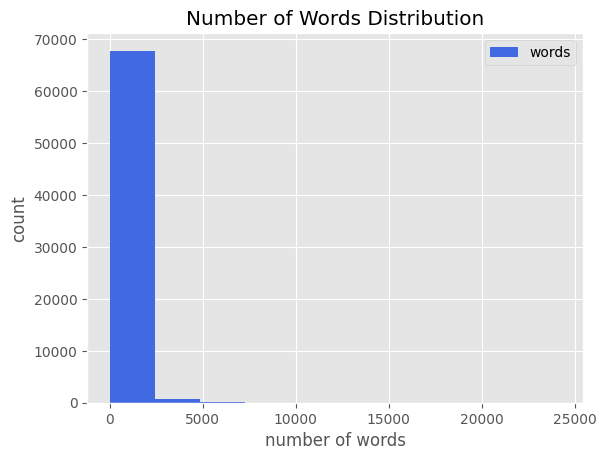

In [ ]:
#count the number of the words for each text in the df by crating the length column
combined_df['words'] = combined_df['text'].apply(lambda row: min(len(row.split(" ")), len(row)) if isinstance(row, str) else None)

#plot hist of number of number of words
plt.style.use('ggplot')
plt.hist(combined_df['words'],
         label="words",
         color="royalblue")
plt.legend(loc='upper right')
plt.title('Number of Words Distribution')
plt.xlabel('number of words')
plt.ylabel('count')
plt.show()

#reference: https://stackoverflow.com/questions/6871201/plot-two-histograms-on-single-chart
#reference commment: I researched and adapted the way to display the histogram
#reference: https://stackoverflow.com/questions/73136113/obtain-the-average-lenght-of-words-of-sentences-in-a-dataframe-column
#reference comment: I researched and adapted code to count the average number of words

Looks like there are some significant outliers. As we will proceed to focus on a smaller sub-set of the data for the models we will limit the size of words in the data for exploration to between 20 and 2000.

Preview the adjusted number of words in articles distribution

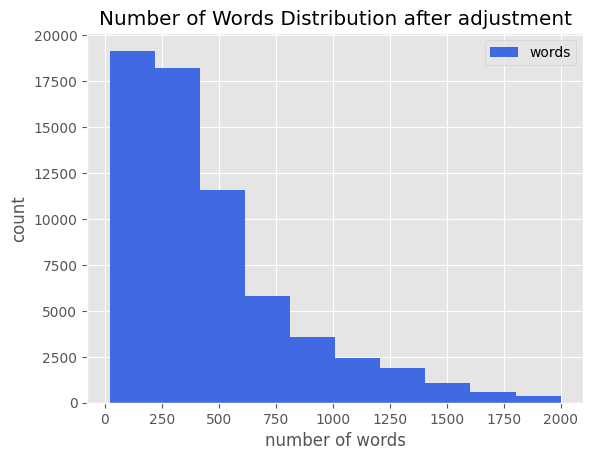

In [ ]:
#remove outliers and limit range
combined_df = combined_df[combined_df.words < 2000]
combined_df = combined_df[combined_df.words > 20]

#plot hist of number of number of words distribution
plt.style.use('ggplot')
plt.hist(combined_df['words'],
         label="words",
         color="royalblue")
plt.legend(loc='upper right')
plt.title('Number of Words Distribution after adjustment')
plt.xlabel('number of words')
plt.ylabel('count')
plt.show()

#reference: https://stackoverflow.com/questions/6871201/plot-two-histograms-on-single-chart
#reference commment: I researched and adapted the way to dsiplay the histogram

From the graph we can infer that the vast majority of articles are below the 1000 words mark with declining articles count as the word count increases.

Preview the adjusted number of words in articles distribution split by fake and real news

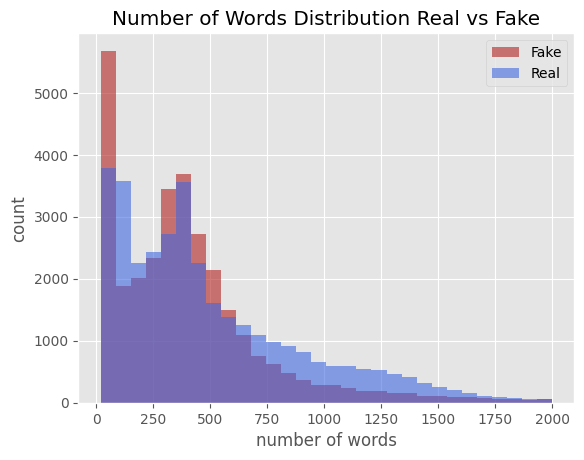

In [ ]:
#plot hist of number of number of words real vs fake
plt.style.use('ggplot')
plt.hist([combined_df.loc[combined_df["real"] == 1, "words"],
          combined_df.loc[combined_df["real"] == 0, "words"]],
         alpha = 0.6,
         bins=30,
         histtype=u'stepfilled',
         label=['Real', 'Fake'],
         color=["royalblue", "firebrick"])
plt.legend(loc='upper right')
plt.title('Number of Words Distribution Real vs Fake')
plt.xlabel('number of words')
plt.ylabel('count')
plt.show()

#reference: https://stackoverflow.com/questions/6871201/plot-two-histograms-on-single-chart
#reference commment: I researched and adapted the code in order to display my histogram in a signle chart
#https://pandas.pydata.org/docs/dev/getting_started/intro_tutorials/03_subset_data.html
#reference commment: I researched and adapted the code to get the right subset of data via pandas documentation
#reference: https://matplotlib.org/stable/gallery/statistics/histogram_histtypes.html
#reference comment: I researched and adapted the code to set the appropriate histagram types and general hist build

From the graph we can see that the distribution of fake news is more concentrated in the lower word counts with a few specific points where as the real news has a longer tail with more articles with longer word counts than the fake news.

Preview the adjusted number of characters in articles distribution split by fake and real news.

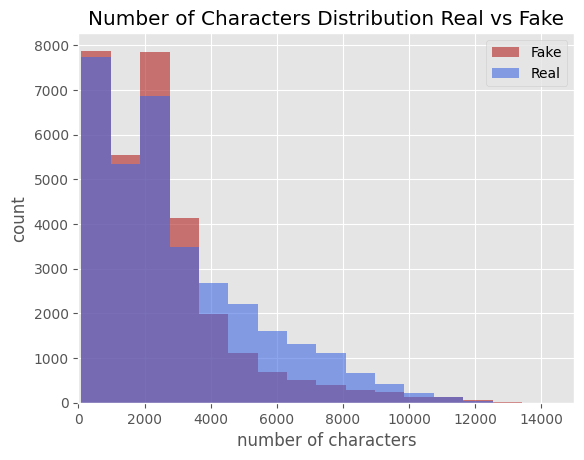

In [ ]:
#calculate the number of characters in text and add as a column
combined_df['characters'] = combined_df['text'].str.len()

#plot hist of number of number of characters
plt.style.use('ggplot')
plt.hist([combined_df.loc[combined_df["real"] == 1, "characters"],
          combined_df.loc[combined_df["real"] == 0, "characters"]],
         alpha = 0.6,
         bins=30,
         histtype=u'stepfilled',
         label=['Real', 'Fake'],
         color=["royalblue", "firebrick"])
plt.legend(loc='upper right')
plt.title('Number of Characters Distribution Real vs Fake')
plt.xlabel('number of characters')
plt.ylabel('count')
plt.xlim(0,15000) #cut off some of the outliers in the graph
plt.show()

#reference: https://stackoverflow.com/questions/6871201/plot-two-histograms-on-single-chart
#reference commment: I researched and adapted the code in order to display my histogram in a signle chart
#reference: https://pandas.pydata.org/docs/dev/getting_started/intro_tutorials/03_subset_data.html
#reference commment: I researched and adapted the code to get the right subset of data via pandas documentation
#reference: https://stackoverflow.com/questions/3777861/how-to-set-the-axis-limits
#reference comment: I reasearched and adapted the code to set the x limit
#reference: https://matplotlib.org/stable/gallery/statistics/histogram_histtypes.html
#reference comment: I researched and adapted the code to set the appropriate histagram types and general hist build

Similarly to the word count distribution the number of character distibutions presents similar distribution characteristics.

Plot the average word length for fake and real data.

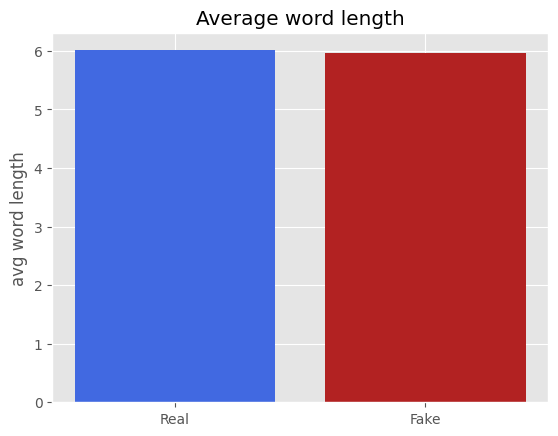

In [ ]:
#calculate the average word length in the text and add as column
combined_df['avg_word_length'] = combined_df['characters']/combined_df['words']

#plot the graph showing the avg word length difference between real and fake data
fig, ax = plt.subplots()
data_type = ['Real','Fake']
counts = [combined_df.loc[combined_df["real"] == 1, "avg_word_length"].mean(),
          combined_df.loc[combined_df["real"] == 0, "avg_word_length"].mean()]
bar_colors = ['royalblue', 'firebrick']
ax.bar(data_type,counts, color=bar_colors)
ax.set_ylabel('avg word length')
ax.set_title('Average word length')
plt.show()

#reference: https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_colors.html#sphx-glr-gallery-lines-bars-and-markers-bar-colors-py
#reference comment: I researched and adapted the code for a graph from the matplotlib documentation to creaty my graph

The average word length per article is very close between the real and fake news articles. No significant differences here.

Separate and pre-process the data for wordclouds.

In [ ]:
#set up a separate df for the next two analysis
wc_df = combined_df

#clean up the data for the next analysis
lemmatizer = WordNetLemmatizer()
for index, row in wc_df.iterrows():
    row['text'] = remove_stopwords(row['text'])
    row['text'] = strip_non_alphanum(row['text'])
    row['text'] = lemmatizer.lemmatize(row['text'])

#create separate true and false sub_dfs
wc_df_df_true = wc_df[wc_df.real == 1]
wc_df_false = wc_df[wc_df.real == 0]

#referemce: https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
#reference comment: I have adapted the code for lemmatization
#reference: https://radimrehurek.com/gensim_4.0.0/parsing/preprocessing.html
#reference commment: I have adapted examples from gensim documentaion to removes topwords and strip alphanumerics

Generate wordclouds for real and fake data.


Real news wordcloud


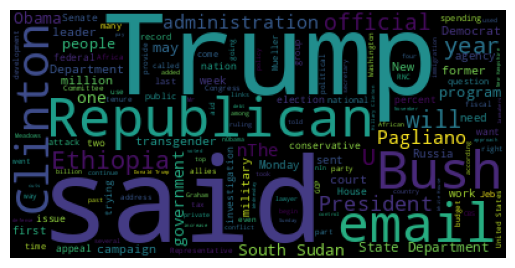



Fake news wordcloud


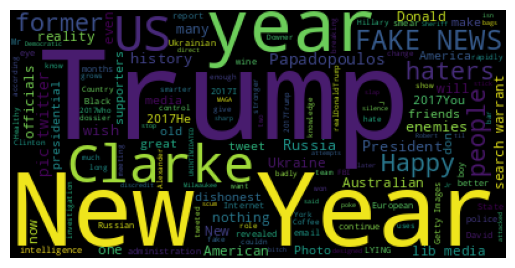

In [ ]:
#set some words to remove any outstanding one-off words or letters
stopwords = set(STOPWORDS)
stopwords.update(["S", "n", "The", "t", "December"])
#december excluded as an outlier

#set up text inputs for the wordclouds
text_input_true = wc_df_df_true["text"].values
text_input_false = wc_df_false["text"].values

#generate a wordcloud for fake news
wordcloud_true = WordCloud(stopwords=stopwords,  max_words=500).generate(str(text_input_true))
wordcloud_fake = WordCloud(stopwords=stopwords,  max_words=500).generate(str(text_input_false))

#print the plots
print("Real news wordcloud")
plt.imshow(wordcloud_true)
plt.axis("off")
plt.show()
print("\n")
print("Fake news wordcloud")
plt.imshow(wordcloud_fake)
plt.axis("off")
plt.show()

#reference: https://www.datacamp.com/tutorial/wordcloud-python
#reference comment: I resarched and adapted the genral wordcloud usage code to create my own wordclouds
#reference: https://stackoverflow.com/questions/43606339/generate-word-cloud-from-single-column-pandas-dataframe
#reference comment: I researched and adapted the code on how to include the data from the dataframe in the wordcloud

Both clouds have a few words in common such as Trump which is expected as both report on news however it is interesting to see that by relative distribution Fake news seems to use it more.

The real news wordcloud brings up some interesting words such as "unoffficial", or "said" pointing to the fact that the articles could be using more references.

The fake news wordcloud interestingly contains a few words such as "FAKE NEWS", "haters" "enemies" "reality" "wish" all indicating certain level of negativity and narratives that the stories attempt to convince the reader of.

Sentiment analysis of real and fake news - checking which sentiment do the news stories lean towards based on the sentiment polarity score

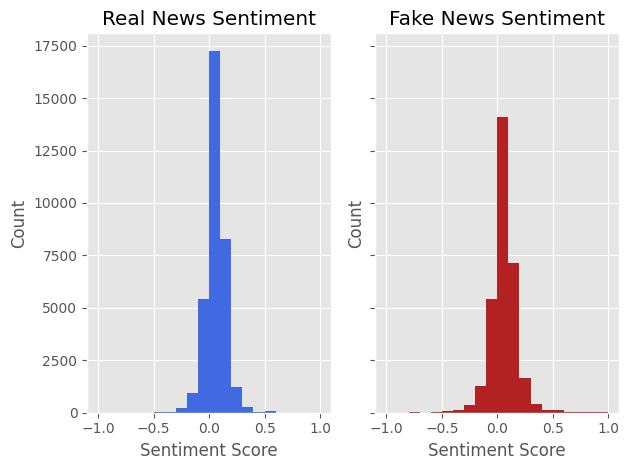

In [ ]:
#set up a function plotting the comparison of sentiment across texts
def plot_polarity_hist_comp(text1, text2):

    #polarity analysis for text
    def _polarity(input_text):
        return TextBlob(input_text).sentiment.polarity

    #calculate polarity scores for each text
    polarity_s_text1 = text1.apply(lambda x : _polarity(x))
    polarity_s_text2 = text2.apply(lambda x : _polarity(x))

    #plot the subplots
    n_bins = 20
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    axs[0].hist(polarity_s_text1,
                bins=n_bins,
                color = "royalblue")
    axs[0].set_title('Real News Sentiment'),
    axs[0].set_xlabel('Sentiment Score'),
    axs[0].set_ylabel('Count')
    axs[1].hist(polarity_s_text2,
                bins=n_bins,
                color = "firebrick"),
    axs[1].set_title('Fake News Sentiment'),
    axs[1].set_xlabel('Sentiment Score'),
    axs[1].set_ylabel('Count')
    plt.show()

#run the function to show the sentiment analysis
plot_polarity_hist_comp(combined_df.loc[combined_df["real"] == 1, "text"],
                        combined_df.loc[combined_df["real"] == 0, "text"])

#reference: https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
#reference comment: I researched and adapted this code in order to create a sentiment analysis of my data and plot it
#reference: https://app.neptune.ai/o/neptune-ai/org/eda-nlp-tools/n/5-0-polarity-score-histogram-7435097b-2554-423d-82f9-a4dfce94ea9b/03b75d0b-4b3b-49c0-a130-b9e63a9e5bf9
#reference comment: I researched and adapted this code in order to create a sentiment analysis of my data and plot it
#reference:https://matplotlib.org/stable/gallery/statistics/hist.html#sphx-glr-gallery-statistics-hist-py
#reference comment: I researched and adapted this code in order to provide the histogram structure
#reference: https://stackoverflow.com/questions/74324444/adding-plot-and-axes-title-to-histogram-subplots
#reference comment: I adapted the way how to add plot titles to subplots

The interesting finding here is that despite both sets being normally distributed the real news tend to be written with a more neutral sentiment where as the distribution of fake news sentiment seems to have a higher deviation and larger tails distribution pointing to fake news articles written with more either positive or negative sentiment.

## Part III - Data Preprocessing

####3.1 General Preprocessing

The analysis using the models is performed on a sub-set of the data due to the maximum model input size and performance requirements.

Remove entries that are longer than 512 words as per the BERT maximum input and remove entries shorter than 20 words to remove the outliers.


In [ ]:
#Remove entries
combined_df = combined_df[combined_df.words < 512]
combined_df = combined_df[combined_df.words > 20]

In [ ]:
combined_df["real"].value_counts()

,count
real,
0,22812
1,21298


The data for the models contains 44,110 articles with 52% of the sample being fake and 48% of them being real.

####3.2 Preprocessing for Traditional Models

Data cleanup for the traditional ML models

In [ ]:
#solution to tfid is running into an issue of unicode items present in the data despite non_alphanumerics removal
combined_df['text'] = combined_df['text'].apply(lambda x: ''.join(char for char in x if char.isalnum() or char.isspace()))

#separate the traditional ml models pre-processing from the pre-processing for the BERT models as they require different approaches.
combined_df_trad = combined_df

#reference: https://saturncloud.io/blog/how-to-remove-special-characters-in-pandas-dataframe/
#reference comment: I researched and adapted this code in order to resolve the unicode issue within my data.

Data pre-processing for the traditional models

In [ ]:
#set all words to lower case
combined_df_trad['text'] = combined_df_trad['text'].str.lower()

#set up lemmatizer
lemmatizer = WordNetLemmatizer()

#apply to all text in df
for index, row in combined_df_trad.iterrows():
    #remove stopwords
    row['text'] = remove_stopwords(row['text'])
    #strip non-alphanumerics
    row['text'] = strip_non_alphanum(row['text'])
    #lemmatize words
    row['text'] = lemmatizer.lemmatize(row['text'])

#referemce: https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
#reference comment: I researched and adapted the code for lemmatization
#reference: https://radimrehurek.com/gensim_4.0.0/parsing/preprocessing.html
#reference commment: I adapted examples from gensim documentaion to removes stopwords and strip alphanumerics

####3.3 Preprocessing for BERT Models

Data pre-processing for the BERT models - only limited cleanup required for BERT model as the bert-preprocessor is used to better retrieve context from unprocessed data.

In [ ]:
#set all words to lower case - BERT model used is lower case
combined_df['text'] = combined_df['text'].str.lower()

####3.4 Train-test Splits

Train-test splits for all models

In [ ]:
#Traintest split for traditonal models
X_train_trad, X_test_trad, y_train_trad, y_test_trad = train_test_split(
    combined_df_trad["text"], combined_df_trad["real"], test_size=0.20, random_state=41)
#no validation set required for tuning as its covered by CV withing sklearn

#Traintest split for BERT Models
X_train, X_test, y_train, y_test = train_test_split(
    combined_df["text"], combined_df["real"], test_size=0.20, random_state=41)

#set up a validation set for BERT models using the nested hold out validation approach in Keras
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(
    X_train, y_train, test_size=0.20, random_state=41)

#reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
#reference comment: code adapted from the scikit learn documentation example

####3.5 Data Vectorisation for Traditional Models

Data Vectorisation for traidional models

In [ ]:
#apply tfid vectorisation on train and test data for traditional models
TfidVect = TfidfVectorizer()
Tfid_X_train_trad = TfidVect.fit_transform(X_train_trad)
Tfid_X_test_trad = TfidVect.transform(X_test_trad)

#reference: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
#reference comment: I adapted the code from the sklearn TfidfVectorizer documentation example

## Part IV - Traditional Models

#### 4.1 Setup for models

Setup results arrays and functions to save and store the results of the models and easily display them at the end of the notebook.

In [ ]:
#set up results arrays to store perfomance results of models for simple graphing later
results_array_model = []
results_array_result_accuracy = []
results_array_result_f1 = []
results_array_result_precision = []
results_array_result_recall = []
results_array_execution_time = []
results_array_modeltrainingcost =[]

#function that adds all results of the model into the dictionaries
def save_results(model_label, model, test_data, start_time, end_time):
  #append all kinds of results into dedicated arrays
  results_array_model.append(model_label)
  results_array_result_accuracy.append(round(metrics.accuracy_score(model, test_data),4))
  results_array_result_f1.append(round(metrics.f1_score(model, test_data),4))
  results_array_result_precision.append(round(metrics.precision_score(model, test_data),4))
  results_array_result_recall.append(round(metrics.recall_score(model, test_data),4))
  results_array_execution_time.append(round((end_time - start_time),4))

  #as the GPU and CPU are used for different models and have different costs we differenciate here
  if model_label == "NB" or model_label == "LR" or model_label == "DT" or model_label == "RF":
    results_array_modeltrainingcost.append(round((end_time - start_time)*cpu_usd_sec,4))
  if model_label == "BFT" or model_label == "BTL":
    results_array_modeltrainingcost.append(round((end_time - start_time)*A100_usd_sec,4))

#reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#
#reference comment: I adapted the code to apply the performance metric
#reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
#reference comment: I adapted the code to apply the performance metric
#reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
#reference comment: I adapted the code to apply the performance metric
#reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
#reference comment: I adapted the code to apply the performance metric

#### 4.2 Naive Bayes Model

Run and evaluate the Naive Bayes model

In [ ]:
#set up the NB model
NB_model = MultinomialNB()

#track training time
start_time = time.time()
#fit the model on training data
NB_model.fit(Tfid_X_train_trad, y_train)
#end tracking time training time
end_time = time.time()

#test models performance on test data
solved_NB_model = NB_model.predict(Tfid_X_test_trad)

#save results to the appropriate result arrays via save_results function
save_results("NB", solved_NB_model, y_test_trad, start_time, end_time)

#print results as the classification report
print(classification_report(y_test, solved_NB_model))

#reference: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB
#reference comment: I adapted the code from the sklearn MultinomialNB documentation example
#reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
#reference comment: I adapted the code from documentation to perform the the performance overview

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      4602
           1       0.88      0.89      0.88      4220

    accuracy                           0.89      8822
   macro avg       0.89      0.89      0.89      8822
weighted avg       0.89      0.89      0.89      8822



###4.3 Logistic Regression Model

Logistic regression with tuning hyperparameters using random search.

In [ ]:
#set up parameters for random search
param_dist = {'C': [0.1, 1, 10, 100, 1000],
              'penalty':['none', 'l2'],
              'max_iter':[100, 500, 1000],
              'solver': ['saga', 'lbfgs', 'newton-cg', 'sag', 'liblinear',]
              }

#set up the LR model and run RS
LR_model = LogisticRegression(random_state=41)

#set up random search to optimize hypeprameters
RS_search_LR = RandomizedSearchCV(LR_model,
                                  param_distributions=param_dist,
                                  n_iter=10,
                                  verbose = 2,
                                  cv=5,
                                  random_state=41)

#fit the random search
RS_search_LR.fit(Tfid_X_train_trad, y_train_trad)

#print the best parameters to be used
print("LR Best Parameters: ")
RS_search_LR.best_params_

#rerence: https://stackoverflow.com/questions/19018333/gridsearchcv-on-logisticregression-in-scikit-learn
#reference comment: I researched and adapted code in relation to the setup of hyperparameters for tuning
#reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
#reference comment: I researched and adapted code in relation to the setup of hyperparameters for tuning
#reference:https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#reference comment: I researched and adapted code from the documentation examples to perform logistic regression
#reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
#reference comment: I researched and adapted code from the documentation examples to perform logistic regression

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .C=100, max_iter=1000, penalty=l2, solver=liblinear; total time=   3.1s
[CV] END .C=100, max_iter=1000, penalty=l2, solver=liblinear; total time=   3.3s
[CV] END .C=100, max_iter=1000, penalty=l2, solver=liblinear; total time=   5.5s
[CV] END .C=100, max_iter=1000, penalty=l2, solver=liblinear; total time=   3.4s
[CV] END .C=100, max_iter=1000, penalty=l2, solver=liblinear; total time=   2.9s
[CV] END .......C=1000, max_iter=100, penalty=l2, solver=sag; total time=   6.5s
[CV] END .......C=1000, max_iter=100, penalty=l2, solver=sag; total time=   6.4s
[CV] END .......C=1000, max_iter=100, penalty=l2, solver=sag; total time=   6.5s
[CV] END .......C=1000, max_iter=100, penalty=l2, solver=sag; total time=   6.5s
[CV] END .......C=1000, max_iter=100, penalty=l2, solver=sag; total time=   6.5s
[CV] END ......C=1000, max_iter=500, penalty=l2, solver=saga; total time=  35.1s
[CV] END ......C=1000, max_iter=500, penalty=l2,

{'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 1000, 'C': 100}

Use the best parameters from random search to fit the model on training data and test on test data.

In [ ]:
#get best prameters and apply them to the new LR model
tuned_LRmodel = LogisticRegression(**RS_search_LR.best_params_)

#track training time
start_time = time.time()
#fit the model on training data
tuned_LRmodel.fit(Tfid_X_train_trad, y_train_trad)
#end tracking time training time
end_time = time.time()

#test models performance on test data
solved_tunded_LR_model = tuned_LRmodel.predict(Tfid_X_test_trad)

#save results to the appropriate result arrays via save_results function
save_results("LR", solved_tunded_LR_model, y_test_trad, start_time, end_time)

#print results as the classification report
print(classification_report(y_test_trad, solved_tunded_LR_model))

#reference: https://stackoverflow.com/questions/45074698/how-to-pass-elegantly-sklearns-gridseachcvs-best-parameters-to-another-model
#reference comment: I adapted the code relating to how to pass on the best parameters out of the gridsearch/randomsearch into a new model
#reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
#reference comment: I adapted the code from documentation to perform the the performance overview
#reference:https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#reference comment: I researched and adapted code from the documentation examples to perform logistic regression

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      4602
           1       0.97      0.96      0.96      4220

    accuracy                           0.96      8822
   macro avg       0.96      0.96      0.96      8822
weighted avg       0.96      0.96      0.96      8822



###4.4 Decision Trees Model

Decision Trees with tuning hyperparameters using random search.


In [ ]:
#set up parameters for random search
param_dist = {
    'max_depth': [3, 10, 20, None],
    'min_samples_split': [1, 2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ["auto ", "sqrt", "log2", None]
}

#set up the DT model and run RS
dtree = DecisionTreeClassifier(random_state=41)

#set up random search to optimize hypeprameters
RS_search_DT = RandomizedSearchCV(dtree, param_distributions=param_dist,
                                  n_iter=30,
                                  verbose = 2,
                                  cv=5,
                                  scoring="accuracy",
                                  random_state=41)

#fit the random search
RS_search_DT.fit(Tfid_X_train_trad, y_train_trad)

#print the best parameters to be used
print("DT Best Parameters: ")
RS_search_DT.best_params_

#rerence: https://scikit-learn.org/stable/modules/tree.html
#reference comment: I researched and adapted code from the documentation examples to perform decision trees classification
#reference: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
#reference comment: I researched and adapted code from the documentation examples to perform decision trees classification
#reference: https://medium.com/@hammad.ai/tuning-model-hyperparameters-with-random-search-f4c1cc88f528
#reference comment: I researched and adapted code in relation to the setup of hyperparameters for for tuning
#reference: https://www.geeksforgeeks.org/how-to-tune-a-decision-tree-in-hyperparameter-tuning/
#reference comment:  I researched and adapted code in relation to the setup of hyperparameters for for tuning

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5; total time=   0.2s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5; total time=   0.2s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5; total time=   0.2s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5; total time=   0.2s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5; total time=   0.2s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=1; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=1; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=1; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=1; total time=   0.0s
[CV] END max_depth=3, max_fea

{'min_samples_split': 5,
 'min_samples_leaf': 10,
 'max_features': None,
 'max_depth': 20}

Use the best parameters from random search to fit the model on training data and test on test data.

In [ ]:
#get best prameters and apply them to the new DT model
tuned_DTmodel = DecisionTreeClassifier(**RS_search_DT.best_params_)

#track training time
start_time = time.time()
#fit the model on training data
tuned_DTmodel.fit(Tfid_X_train_trad, y_train_trad)
#end tracking time training time
end_time = time.time()

#test models performance on test data
solved_tunded_DT_model = tuned_DTmodel.predict(Tfid_X_test_trad)

#save results to the appropriate result arrays via save_results function
save_results("DT", solved_tunded_DT_model, y_test_trad, start_time, end_time)

#print results as the classification report
print(classification_report(y_test_trad, solved_tunded_DT_model))

#reference: https://stackoverflow.com/questions/45074698/how-to-pass-elegantly-sklearns-gridseachcvs-best-parameters-to-another-model
#reference comment: I adapted the code relating to how to pass on the best parameters out of the gridsearch/randomsearch into a new model
#reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
#reference comment: I adapted the code from documentation to perform the the performance overview
#rerence: https://scikit-learn.org/stable/modules/tree.html
#reference comment: I researched and adapted code from the documentation examples to perform decision trees classification
#reference: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
#reference comment: I researched and adapted code from the documentation examples to perform decision trees classification

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4602
           1       0.89      0.89      0.89      4220

    accuracy                           0.89      8822
   macro avg       0.89      0.89      0.89      8822
weighted avg       0.89      0.89      0.89      8822



###4.5 Random Forest Model

Random Forest with tuning hyperparameters using random search.

In [ ]:
#set up parameters for random search
param_dist = {
    'n_estimators': [10, 20, 50, 100, 150],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [2, 4, 6, 8, None],
    'max_leaf_nodes': [2, 5, 10, 25, 75, 100, None],
}

#set up the RF model and run RS
RF_model = RandomForestClassifier(random_state=41)

#set up random search to optimize hypeprameters
RS_search_RF = RandomizedSearchCV(RF_model,
                                  param_distributions=param_dist,
                                  n_iter=10,
                                  verbose = 2,
                                  cv=5,
                                  random_state=41)

#fit the random search
RS_search_RF.fit(Tfid_X_train_trad, y_train_trad)

#print the best parameters to be used
print("RF Best Parameters: ")
RS_search_RF.best_params_

#rerence: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#reference comment: I researched and adapted code from the documentation examples to perform random forrest classification
#reference: https://www.geeksforgeeks.org/random-forest-hyperparameter-tuning-in-python/
#reference comment: I researched and adapted code in relation to the setup of hyperparameters for  for tuning
#reference:https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/#:~:text=Hyperparameter%20tuning%20in%20decision%20trees,trees%2C%20and%20feature%20selection%20methods
#reference comment: I researched and adapted code in relation to the setup of hyperparameters for  for tuning

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, n_estimators=50; total time= 1.1min
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, n_estimators=50; total time= 1.1min
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, n_estimators=50; total time= 1.1min
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, n_estimators=50; total time= 1.1min
[CV] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, n_estimators=50; total time= 1.1min
[CV] END max_depth=8, max_features=sqrt, max_leaf_nodes=5, n_estimators=10; total time=   0.7s
[CV] END max_depth=8, max_features=sqrt, max_leaf_nodes=5, n_estimators=10; total time=   0.7s
[CV] END max_depth=8, max_features=sqrt, max_leaf_nodes=5, n_estimators=10; total time=   0.7s
[CV] END max_depth=8, max_features=sqrt, max_leaf_nodes=5, n_estimators=10; total time=   0.7s
[CV] END max_depth=8, max_features=sqrt, max_leaf_node

{'n_estimators': 50,
 'max_leaf_nodes': None,
 'max_features': 'sqrt',
 'max_depth': None}

Use the best parameters from random search to fit the model on training data and test on test data.

In [ ]:
#get best prameters and apply them to the new RF model
tuned_RFmodel = RandomForestClassifier(**RS_search_RF.best_params_)

#track training time
start_time = time.time()
#fit the model on training data
tuned_RFmodel.fit(Tfid_X_train_trad, y_train_trad)
#end tracking time training time
end_time = time.time()

#test models performance on test data
solved_tunded_RF_model = tuned_RFmodel.predict(Tfid_X_test_trad)

#save results to the appropriate result arrays via save_results function
save_results("RF", solved_tunded_RF_model, y_test_trad, start_time, end_time)

#print results as the classification report
print(classification_report(y_test_trad, solved_tunded_RF_model))

#reference: https://stackoverflow.com/questions/45074698/how-to-pass-elegantly-sklearns-gridseachcvs-best-parameters-to-another-model
#reference comment: I adapted the code relating to how to pass on the best parameters out of the gridsearch/randomsearch into a new model
#reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
#reference comment: I adapted the code from documentation to perform the the performance overview
#reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#reference comment: I researched and adapted code from the documentation examples to perform random forest classification

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      4602
           1       0.93      0.91      0.92      4220

    accuracy                           0.92      8822
   macro avg       0.92      0.92      0.92      8822
weighted avg       0.92      0.92      0.92      8822



## Part V - BERT Based Models

Create and optimise the 2 BERT based models:


*   BTL - Bert transfer-learning model using frozen Bert layers and custom trainable classifier
*   BFT - BERT fine-tuning model using trainable BERT layers and a custom trainable classifier



####5.1 BERT Transfer-learning Model (BTL Model)

Set up and tune the BTL model

In [ ]:
#set up the BERT preprocessor and encoder
bert_preprocessor = hub.load(
    "https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3")
bert_encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable = False)

#set up BERT layers & preprocessing
text_inputs = tf.keras.layers.Input(shape=(), dtype=tf.string),
tokenize = hub.KerasLayer(bert_preprocessor.tokenize)
tokenized_inputs = [tokenize(segment) for segment in text_inputs]

#solution for bert to accept up to 512 tokens for the long sentences instead of standard 128
seq_length = 512
bert_pack_inputs = hub.KerasLayer(
    bert_preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=seq_length))
encoder_inputs = bert_pack_inputs(tokenized_inputs)
outputs = bert_encoder(encoder_inputs)

#function for with the Keras model for tuning using Keras Tuner later
def build_BTLmodel(hp):
  # Neural network layers post BERT layers
  l = tf.keras.layers.Dropout(hp.Float('Dropout_1_rate',min_value = 0.0, max_value =0.6), name="dropout1")(outputs['pooled_output'])
  l = tf.keras.layers.Dense(hp.Choice('Dense_1_units', [256,512]),name="dense1", activation=hp.Choice('dense_1_activation', ["relu", "tanh"]))(l)
  l = tf.keras.layers.Dropout(hp.Float('Dropout_2_rate',min_value = 0.0, max_value =0.6), name="dropout2")(l)
  l = tf.keras.layers.Dense(hp.Choice('Dense_2_units', [64,128,256]),name="dense2", activation=hp.Choice('dense_2_activation', ["relu", "tanh", "softmax"]))(l)
  l = tf.keras.layers.Dropout(hp.Float('Dropout_3_rate',min_value = 0.0, max_value =0.6), name="dropout3")(l)
  l = tf.keras.layers.Dense(1,name="dense3", activation='sigmoid')(l)
  BTLModel = tf.keras.Model(inputs=[text_inputs], outputs = [l])

  #model metrics to be displayed in training
  metrics_BTL = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')
                 ]

  #compile the model
  BTLModel.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = hp.Choice('Adam_LR', [0.001,
                                                                                              0.0001,
                                                                                              0.00001])),
                loss='binary_crossentropy',
                metrics=metrics_BTL)

  return BTLModel

#set up the keras tuner to optimize the model with hyperband
tuner_BTL = keras_tuner.Hyperband(
    hypermodel=build_BTLmodel,
    objective="val_accuracy",
    factor = 16,
    max_epochs=8,
    overwrite=True,
    directory="BTLTuning_RS",
    project_name="BTLTuning",
)

#set up callback to stop early when the optimal val_loss doesnt improve over several epochs
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

#run the tuner
tuner_BTL.search(X_train_val,
                 y_train_val,
                 epochs=1,
                 validation_data=(X_test_val, y_test_val),
                 callbacks=[stop_early], batch_size=512)

#reference: https://medium.com/@danushidk507/fine-tune-bert-for-text-classification-with-tensorflow-7175c4ab5475
#reference commment: I researched and adapted this code in setting up the BERT model and fine-tuning it
#reference: https://keras.io/api/keras_tuner/tuners/hyperband/
#reference commment: I researched and adapted this code to run the Keras hyperband tunner
#reference: https://www.youtube.com/watch?v=hOCDJyZ6quA
#reference comment: I have researched and adapted the code from the video in order to create the base BERT model, BERT layers, and preprocessing
#reference: https://stackoverflow.com/questions/68936835/how-to-specify-input-sequence-length-for-bert-tokenizer-in-tensorflow
#reference comment: I have researched and adapted the code to expand the tokens input for BERT to 512 tokens
#rerence: https://keras.io/guides/transfer_learning/
#reference comment: I have researched and adapted the code for transfer learning / fine-tuning implementation in keras and the tuner
#reference: https://www.tensorflow.org/tutorials/keras/keras_tuner
#reference comment:  I have researched and adapted the code for transfer learning / fine-tuning and the stoping early call back function and best epoch finding solution
#reference:https://keras.io/keras_tuner/
#reference comment: I have researched and adapted the code for transfer learning / fine-tuning implementation in keras and the tuner
#reference: https://keras.io/guides/keras_tuner/getting_started/
#reference comment: I have researched and adapted the code for transfer learning / fine-tuning implementation in keras and the tuner
#reference: https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3
#reference commment: I researched and adapted the code to import and configure the BERT pre-processor
#reference: https://www.kaggle.com/models/tensorflow/bert/tensorFlow2/en-uncased-l-12-h-768-a-12/4?tfhub-redirect=true
#reference commment: I researched and adapted the code to import and configure the BERT encoder

Trial 2 Complete [01h 37m 37s]
val_accuracy: 0.8498157858848572

Best val_accuracy So Far: 0.8498157858848572
Total elapsed time: 03h 15m 19s


Note to tuning BTL: due to colab A100 GPU availability and common runtime disconnects the the tests are ran with limited number of trials for final execution. This best trial represents in my experience an average result for this model within this specification within +/- 1% to 2% on validation data of other even much more extensive trials.

Get the best model from tuner and display the parameters summary of the model

In [ ]:
#get the best model from the tuner
best_model_BTL = tuner_BTL.get_best_models()[0]

#show the model layers and parameters summary
best_model_BTL.summary()

#reference: https://keras.io/api/models/model/
#reference commment: I have researched and adapted the code for showing the model summary
#reference: https://keras.io/guides/keras_tuner/getting_started/
#reference comment: I have researched and adapted the code for getting the best model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer_1 (KerasLayer)  (None, None, None)           0         ['input_1[0][0]']             
                                                                                                  
 keras_layer_2 (KerasLayer)  {'input_word_ids': (None,    0         ['keras_layer_1[0][0]']       
                             512),                                                                
                              'input_type_ids': (None,                                            
                             512),                                                            

Show the best model's parameters

In [ ]:
#get the results summary from the tuning process for the best model
tuner_BTL.results_summary(1)

#reference: https://keras.io/guides/keras_tuner/getting_started/
#reference comment: I have researched and adapted the code for obtaining the results summary from tuning

Results summary
Results in BTLTuning_RS/BTLTuning
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 0001 summary
Hyperparameters:
Dropout_1_rate: 0.4699831950219852
Dense_1_units: 512
dense_1_activation: tanh
Dropout_2_rate: 0.5412697243521126
Dense_2_units: 64
dense_2_activation: tanh
Dropout_3_rate: 0.25338118175953916
Adam_LR: 0.001
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.8498157858848572


Run the best model to establish the best epoch using validation data

In [ ]:
#get the top 1 hyperparameters from the training
best_hps_BTL = tuner_BTL.get_best_hyperparameters(1)
#build the model with the best hyperparameters
BTLmodel_val = build_BTLmodel(best_hps_BTL[0])

#fit with the entire train dataset and find the opitmal epoch number
history_BTLmodel_val = BTLmodel_val.fit(x=X_train_val, y=y_train_val, epochs=15, validation_data = (X_test_val, y_test_val))
val_acc_per_epoch = history_BTLmodel_val.history['val_accuracy']
best_epoch_BTLmodel_val = val_acc_per_epoch.index(max(val_acc_per_epoch))+1
print('Best epoch: %d' % (best_epoch_BTLmodel_val,))

#reference: https://www.tensorflow.org/tutorials/keras/keras_tuner
#reference comment:  I have researched and adapted the code the stoping early call back function and best epoch finding solution
#reference: https://keras.io/guides/keras_tuner/getting_started/
#reference comment: I have researched and adapted the code for transfer learning / fine-tuning implementation in keras and applying the best hyperparameters

Epoch 1/15
883/883 [==============================] - 353s 397ms/step - loss: 0.5998 - accuracy: 0.6859 - precision: 0.6805 - recall: 0.6589 - val_loss: 0.4237 - val_accuracy: 0.8185 - val_precision: 0.8093 - val_recall: 0.8222
Epoch 2/15
883/883 [==============================] - 349s 395ms/step - loss: 0.5146 - accuracy: 0.7552 - precision: 0.7553 - recall: 0.7291 - val_loss: 0.4231 - val_accuracy: 0.8185 - val_precision: 0.9099 - val_recall: 0.6974
Epoch 3/15
883/883 [==============================] - 349s 395ms/step - loss: 0.4960 - accuracy: 0.7692 - precision: 0.7702 - recall: 0.7440 - val_loss: 0.3820 - val_accuracy: 0.8400 - val_precision: 0.8663 - val_recall: 0.7952
Epoch 4/15
883/883 [==============================] - 349s 396ms/step - loss: 0.4797 - accuracy: 0.7789 - precision: 0.7816 - recall: 0.7523 - val_loss: 0.3741 - val_accuracy: 0.8517 - val_precision: 0.8448 - val_recall: 0.8529
Epoch 5/15
883/883 [==============================] - 349s 395ms/step - loss: 0.4678 - a

Display the training history graphs for the model

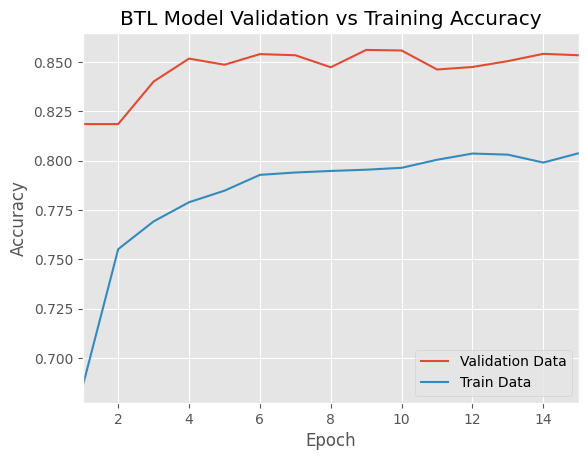

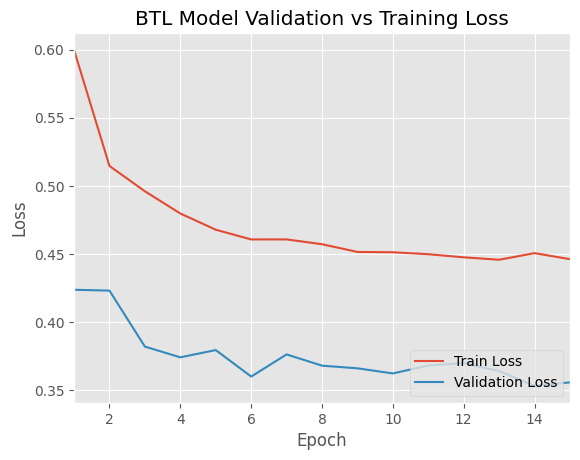

In [ ]:
#print graphs of val accuracy and loss

#val accuracy graph
plt.plot([history_BTLmodel_val.history["val_accuracy"][0]] + history_BTLmodel_val.history["val_accuracy"]) #set epoch number equal to epoch count for graph
plt.plot([history_BTLmodel_val.history["accuracy"][0]] + history_BTLmodel_val.history["accuracy"]) #set epoch number equal to epoch count for graph
plt.title("BTL Model Validation vs Training Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Validation Data", "Train Data"], loc="lower right")
plt.xlim(1,len(history_BTLmodel_val.history["val_accuracy"]))  #show x axis from 1
plt.show()

#loss graph
plt.plot([history_BTLmodel_val.history["loss"][0]] + history_BTLmodel_val.history["loss"]) #set epoch number equal to epoch count for graph
plt.plot([history_BTLmodel_val.history["val_loss"][0]] + history_BTLmodel_val.history["val_loss"]) #set epoch number equal to epoch count for graph
plt.title("BTL Model Validation vs Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train Loss", "Validation Loss"], loc="lower right")
plt.xlim(1,len(history_BTLmodel_val.history["loss"])) #show x axis from 1
plt.show()

#rerence: https://stackoverflow.com/questions/66785014/how-to-plot-the-accuracy-and-and-loss-from-this-keras-cnn-model
#reference comment: I researched and adapted the code to create model graphs for validation accuracy and loss

Note: the colors of the train and validation data are different colors across the 2 graphs - found post final execution post runtime disconnect

fit the model with the entire training dataset with optimal hyperparameters and the best epochs number and test on test data.

In [ ]:
#BTL model fit with the entire training dataset with optimal HP and optimal epochs

#build final model with best params
BTLmodel_final = build_BTLmodel(best_hps_BTL[0])

#track training time
start_time = time.time()
#fit best model over optimal epoch number
BTLmodel_final.fit(x=X_train, y=y_train, epochs=best_epoch_BTLmodel_val)
#end tracking time training time
end_time = time.time()

#test on model on real test data and provide classification report
solved_tunded_BTL_model = BTLmodel_final.predict(X_test).flatten()
solved_tunded_BTL_model = np.where(solved_tunded_BTL_model > 0.5, 1, 0)
print(classification_report(y_test, solved_tunded_BTL_model))

#save results to the appropriate result arrays via save_results function
save_results("BTL", solved_tunded_BTL_model, y_test, start_time, end_time)

#reference: https://keras.io/guides/keras_tuner/getting_started/
#reference comment: I have researched and adapted the code for transfer learning / fine-tuning implementation in keras and testing the final model on real test data
#rerence: https://keras.io/guides/transfer_learning/
#reference comment: I have researched and adapted the code for transfer learning / fine-tuning implementation in keras and the tuner
#reference: https://www.tensorflow.org/tutorials/keras/keras_tuner
#reference comment:  I have researched and adapted the code for transfer learning / fine-tuning and the stoping early call back function and best epoch finding solution
#reference:https://keras.io/keras_tuner/
#reference comment: I have researched and adapted the code for transfer learning / fine-tuning implementation in keras and the tuner
#reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
#reference comment: I adapted the code from documentation to perform the the performance overview

Epoch 1/9
1103/1103 [==============================] - 353s 317ms/step - loss: 0.5917 - accuracy: 0.6944 - precision: 0.6889 - recall: 0.6720
Epoch 2/9
1103/1103 [==============================] - 350s 317ms/step - loss: 0.5111 - accuracy: 0.7580 - precision: 0.7592 - recall: 0.7324
Epoch 3/9
1103/1103 [==============================] - 350s 317ms/step - loss: 0.4871 - accuracy: 0.7747 - precision: 0.7781 - recall: 0.7476
Epoch 4/9
1103/1103 [==============================] - 350s 317ms/step - loss: 0.4687 - accuracy: 0.7839 - precision: 0.7868 - recall: 0.7594
Epoch 5/9
1103/1103 [==============================] - 350s 317ms/step - loss: 0.4655 - accuracy: 0.7879 - precision: 0.7943 - recall: 0.7579
Epoch 6/9
1103/1103 [==============================] - 350s 317ms/step - loss: 0.4609 - accuracy: 0.7920 - precision: 0.7993 - recall: 0.7614
Epoch 7/9
1103/1103 [==============================] - 350s 317ms/step - loss: 0.4556 - accuracy: 0.7955 - precision: 0.8017 - recall: 0.7671
Epoch 

####5.2 BERT Fine-tuning Model (BFT Model)

Set up and tune the BFT model

In [ ]:
#set up the BERT preprocessor and encoder
bert_preprocessor = hub.load(
    "https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3")
bert_encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable = True)

#set up BERT layers & preprocessing
text_inputs = tf.keras.layers.Input(shape=(), dtype=tf.string),
tokenize = hub.KerasLayer(bert_preprocessor.tokenize)
tokenized_inputs = [tokenize(segment) for segment in text_inputs]

#solution for bert to accept up to 512 tokens for the long sentences instead of standard 128
seq_length = 512
bert_pack_inputs = hub.KerasLayer(
    bert_preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=seq_length))
encoder_inputs = bert_pack_inputs(tokenized_inputs)
outputs = bert_encoder(encoder_inputs)

#function for with the Keras model for tuning using Keras Tuner later
def build_BFTmodel(hp):
  # Neural network layers post BERT layers
  l = tf.keras.layers.Dropout(hp.Float('Dropout_1_rate',min_value = 0.0, max_value =0.6), name="dropout1")(outputs['pooled_output'])
  l = tf.keras.layers.Dense(hp.Choice('Dense_1_units', [256,512]),name="dense1", activation=hp.Choice('dense_1_activation', ["relu", "tanh"]))(l)
  l = tf.keras.layers.Dense(hp.Choice('Dense_2_units', [64,128,256]),name="dense2", activation=hp.Choice('dense_2_activation', ["relu", "tanh", "softmax"]))(l)
  l = tf.keras.layers.Dense(1,name="dense3", activation='sigmoid')(l)
  BFTModel = tf.keras.Model(inputs=[text_inputs], outputs = [l])

  #model metrics to be displayed in training
  metrics_BFT = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')
                 ]

  #compile the model
  BFTModel.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = hp.Choice('Adam_LR', [2e-5, 2e-6])),
                   loss='binary_crossentropy',
                   metrics=metrics_BFT)

  return BFTModel

#set up the keras tuner to optimize the model with random search as the search space is not as large as BTL
tuner_BFT = keras_tuner.RandomSearch(
    hypermodel=build_BFTmodel,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="BFTTuning_RS",
    project_name="BFTTuning",
)

#set up callback to stop early when the optimal val_loss doesnt improve over several epochs
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

#run the tuner
tuner_BFT.search(X_train_val, y_train_val, epochs=2, validation_data=(X_test_val, y_test_val))
best_model = tuner_BFT.get_best_models()[0]

#reference: https://medium.com/@danushidk507/fine-tune-bert-for-text-classification-with-tensorflow-7175c4ab5475
#reference commment: I researched and adapted this code in setting up the BERT model and fine-tuning it
#reference: https://www.youtube.com/watch?v=hOCDJyZ6quA
#reference comment: I have researched and adapted the code from the video in order to create the base BERT model, BERT layers, and preprocessing
#reference: https://stackoverflow.com/questions/68936835/how-to-specify-input-sequence-length-for-bert-tokenizer-in-tensorflow
#reference comment: I have researched and adapted the code to expand the tokens input for BERT to 512 tokens
#rerence: https://keras.io/guides/transfer_learning/
#reference comment: I have researched and adapted the code for transfer learning / fine-tuning implementation in keras and the tuner
#reference: https://www.tensorflow.org/tutorials/keras/keras_tuner
#reference comment:  I have researched and adapted the code for transfer learning / fine-tuning and the stoping early call back function and best epoch finding solution
#reference:https://keras.io/keras_tuner/
#reference comment: I have researched and adapted the code for transfer learning / fine-tuning implementation in keras and the tuner
#reference: https://keras.io/guides/keras_tuner/getting_started/
#reference comment: I have researched and adapted the code for transfer learning / fine-tuning implementation in keras and the tuner
#reference: https://keras.io/api/keras_tuner/tuners/random/
#refernce comment: I researched and adapted the code to use the keras tuner with random search
#reference: https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3
#reference commment: I researched and adapted the code to import and configure the BERT pre-processor
#reference: https://www.kaggle.com/models/tensorflow/bert/tensorFlow2/en-uncased-l-12-h-768-a-12/4?tfhub-redirect=true
#reference commment: I researched and adapted the code to import and configure the BERT encoder

Trial 10 Complete [00h 29m 01s]
val_accuracy: 0.9906489253044128

Best val_accuracy So Far: 0.9910739660263062
Total elapsed time: 04h 50m 14s


Get the best model from tuner and display the parameters summary of the model

In [ ]:
#get the best model from the tuner
best_model_BFT = tuner_BFT.get_best_models()[0]

#show the model layers and parameters summary
best_model_BFT.summary()

#reference: https://keras.io/api/models/model/
#reference commment: I have researched and adapted the code for showing the model summary
#reference: https://keras.io/guides/keras_tuner/getting_started/
#reference comment: I have researched and adapted the code for getting the best model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer_1 (KerasLayer)  (None, None, None)           0         ['input_1[0][0]']             
                                                                                                  
 keras_layer_2 (KerasLayer)  {'input_word_ids': (None,    0         ['keras_layer_1[0][0]']       
                             512),                                                                
                              'input_type_ids': (None,                                            
                             512),                                                            

Show the best model's parameters

In [ ]:
#get the results summary from the tuning process for the best model
tuner_BFT.results_summary(1)

#reference: https://keras.io/guides/keras_tuner/getting_started/
#reference comment: I have researched and adapted the code for obtaining the results summary from tuning

Results summary
Results in BFTTuning_RS/BFTTuning
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
Dropout_1_rate: 0.29251213927767816
Dense_1_units: 512
dense_1_activation: relu
Dense_2_units: 256
dense_2_activation: relu
Adam_LR: 2e-06
Score: 0.9910739660263062


Run the best model to establish the best epoch using validation data

In [ ]:
#get the top 1 hyperparameters from the training
best_hps_BFT = tuner_BFT.get_best_hyperparameters(1)
#build the model with the best hyperparameters
BFTmodel_val = build_BTLmodel(best_hps_BFT[0])

#fit with the entire dataset and find the opitmal epoch number
model_BFT_hist = BFTmodel_val.fit(x=X_train_val, y=y_train_val, epochs=7, validation_data = (X_test_val, y_test_val))
val_acc_per_epoch = model_BFT_hist.history['val_accuracy']
best_epoch_BFTmodel = val_acc_per_epoch.index(max(val_acc_per_epoch))+1
print('Best epoch: %d' % (best_epoch_BFTmodel,))

#reference: https://www.tensorflow.org/tutorials/keras/keras_tuner
#reference comment:  I have researched and adapted the code the stoping early call back function and best epoch finding solution
#reference: https://keras.io/guides/keras_tuner/getting_started/
#reference comment: I have researched and adapted the code for transfer learning / fine-tuning implementation in keras and applying the best hyperparameters

Epoch 1/7
883/883 [==============================] - 883s 969ms/step - loss: 0.0638 - accuracy: 0.9859 - precision: 0.9979 - recall: 0.9729 - val_loss: 0.0405 - val_accuracy: 0.9911 - val_precision: 0.9936 - val_recall: 0.9881
Epoch 2/7
883/883 [==============================] - 853s 966ms/step - loss: 0.0072 - accuracy: 0.9990 - precision: 0.9988 - recall: 0.9992 - val_loss: 0.0467 - val_accuracy: 0.9902 - val_precision: 0.9898 - val_recall: 0.9901
Epoch 3/7
883/883 [==============================] - 853s 966ms/step - loss: 0.0048 - accuracy: 0.9993 - precision: 0.9992 - recall: 0.9993 - val_loss: 0.0490 - val_accuracy: 0.9887 - val_precision: 0.9850 - val_recall: 0.9919
Epoch 4/7
883/883 [==============================] - 853s 966ms/step - loss: 0.0041 - accuracy: 0.9994 - precision: 0.9993 - recall: 0.9994 - val_loss: 0.0417 - val_accuracy: 0.9905 - val_precision: 0.9930 - val_recall: 0.9875
Epoch 5/7
883/883 [==============================] - 853s 966ms/step - loss: 0.0034 - accura

Display the training history graphs for the model

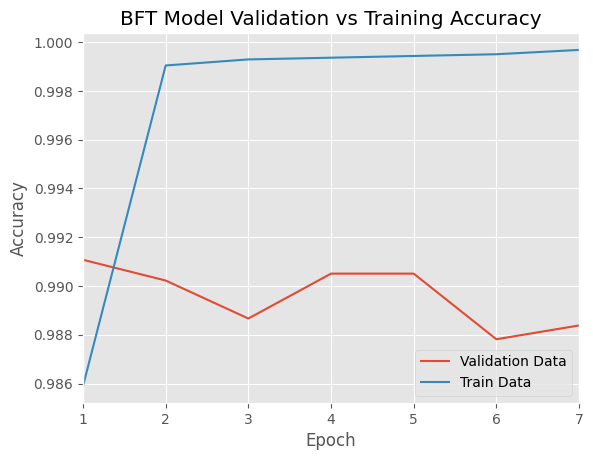

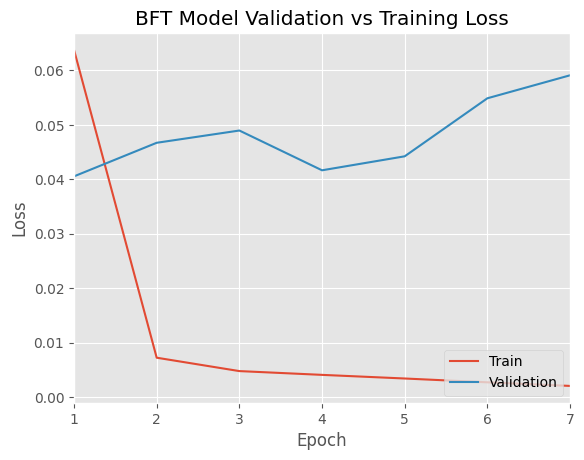

In [ ]:
#print graphs of val accuracy and loss

#val accuracy graph
plt.plot([model_BFT_hist.history["val_accuracy"][0]] + model_BFT_hist.history["val_accuracy"]) #set epoch number equal to epoch count for graph
plt.plot([model_BFT_hist.history["accuracy"][0]] + model_BFT_hist.history["accuracy"]) #set epoch number equal to epoch count for graph
plt.title("BFT Model Validation vs Training Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Validation Data", "Train Data"], loc="lower right")
plt.xlim(1,len(model_BFT_hist.history["val_accuracy"])) #show xaxis from 1
plt.show()

#loss graph
plt.plot([model_BFT_hist.history["loss"][0]] + model_BFT_hist.history["loss"]) #set epoch number equal to epoch count for graph
plt.plot([model_BFT_hist.history["val_loss"][0]] + model_BFT_hist.history["val_loss"]) #set epoch number equal to epoch count for graph
plt.title("BFT Model Validation vs Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="lower right")
plt.xlim(1,len(model_BFT_hist.history["loss"])) #show xaxis from 1
plt.show()

#rerence: https://stackoverflow.com/questions/66785014/how-to-plot-the-accuracy-and-and-loss-from-this-keras-cnn-model
#reference comment: I researched and adapted the code to create model graphs for validation accuracy and loss

Note: the colors of the train and validation data are different colors across the 2 graphs - found post final execution post runtime disconnect

fit the model with the entire training dataset with optimal hyperparameters and the best epochs number and test on test data.

In [ ]:
#set the BFTmodel to use
BFTmodel = build_BTLmodel(best_hps_BFT[0])

#track training time
start_time = time.time()
#fit best model over optimal epoch number
BFTmodel.fit(x=X_train, y=y_train, epochs=best_epoch_BFTmodel)
#end tracking time training time
end_time = time.time()

#test on model on real test data and provide classification report
solved_tunded_BFT_model = BFTmodel.predict(X_test).flatten()
solved_tunded_BFT_model = np.where(solved_tunded_BFT_model > 0.5, 1, 0)
print(classification_report(y_test, solved_tunded_BFT_model))

#save results to the appropriate result arrays via save_results function
save_results("BFT", solved_tunded_BFT_model, y_test, start_time, end_time)

#reference: https://keras.io/guides/keras_tuner/getting_started/
#reference comment: I have researched and adapted the code for transfer learning / fine-tuning implementation in keras and testing the final model on real test data
#rerence: https://keras.io/guides/transfer_learning/
#reference comment: I have researched and adapted the code for transfer learning / fine-tuning implementation in keras and the tuner
#reference: https://www.tensorflow.org/tutorials/keras/keras_tuner
#reference comment:  I have researched and adapted the code for transfer learning / fine-tuning and the stoping early call back function and best epoch finding solution
#reference:https://keras.io/keras_tuner/
#reference comment: I have researched and adapted the code for transfer learning / fine-tuning implementation in keras and the tuner
#reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
#reference comment: I adapted the code from documentation to perform the the performance overview

276/276 [==============================] - 88s 315ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4602
           1       0.98      0.99      0.99      4220

    accuracy                           0.99      8822
   macro avg       0.99      0.99      0.99      8822
weighted avg       0.99      0.99      0.99      8822



## Part VI - Results Comparison

####6.1 Comparison Setup

Set up the graphing functions for results comparison

In [ ]:
#function that add result labels to the graphs
def add_graph_labels_mid(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

#standardised function to draw the results graph
def draw_results_graph(result_array, title, y_label):
  fig, ax = plt.subplots()
  ax.bar(results_array_model, result_array, label=results_array_model)
  ax.set_ylabel(title)
  ax.set_title(y_label)
  add_graph_labels_mid(results_array_model,result_array)
  plt.show()

#function to draw confusion matrices
def draw_results_cf(model_name, solved_model, y_test_data):
  fig, ax = plt.subplots(figsize=(5, 5))
  NB_CM = ConfusionMatrixDisplay.from_predictions(y_test_trad, solved_model, ax=ax)
  NB_CM.ax_.set(
                  title= model_name,
                  xlabel='Predicted',
                  ylabel='Actual')

#reference:https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_colors.html#sphx-glr-gallery-lines-bars-and-markers-bar-colors-py
#reference comment: I adapted the code from the video in order to create the graph
#reference:https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/
#reference comment: I adapted this code to create the add_graph_labels_mid function and add the result labels to the graph appropriately in the middle of the bar
#reference: https://blog.finxter.com/how-to-plot-sklearn-confusion-matrix-with-labels/
#reference commment: adapted code to add labels to the confusion matrix
#reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
#reference comment: I adapted the code to draw confusion matrices
#reference: https://stackoverflow.com/questions/61325314/how-to-change-plot-confusion-matrix-default-figure-size-in-sklearn-metrics-packa
#reference commment: I adapted a solution to make the matrices smaller

####6.2 Final Results Comparison

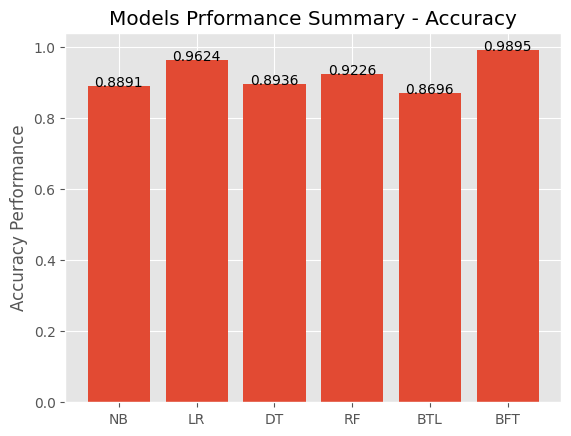

In [ ]:
#draw accuracy results graph
draw_results_graph(results_array_result_accuracy,
                   'Accuracy Performance',
                   'Models Prformance Summary - Accuracy')

The BFT performed best achieving almost 99% accuracy and outperforming all other models. The second best in terms of accuracy was the LR model. BTL has underperformed in comparison to other traditional models.

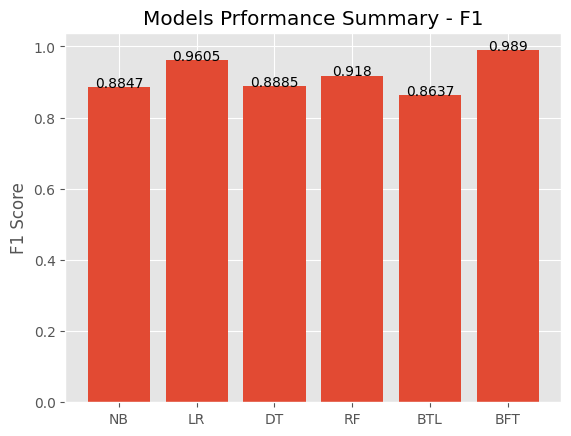

In [ ]:
#draw F1 results graph
draw_results_graph(results_array_result_f1,
                   'F1 Score',
                   'Models Prformance Summary - F1')

In terms of F1 The BFT performed best with close to 99% with logistic regression close behind at 96%. BTL has underperformed traditional model.

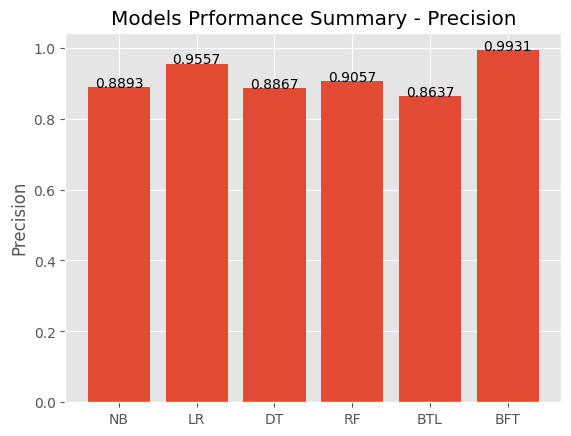

In [ ]:
#draw precision results graph
draw_results_graph(results_array_result_precision,
                   'Precision',
                   'Models Prformance Summary - Precision')

In terms of precision BFT has outperformed all models, followed by Logistic Regression. BTL has underperformed traditional models.

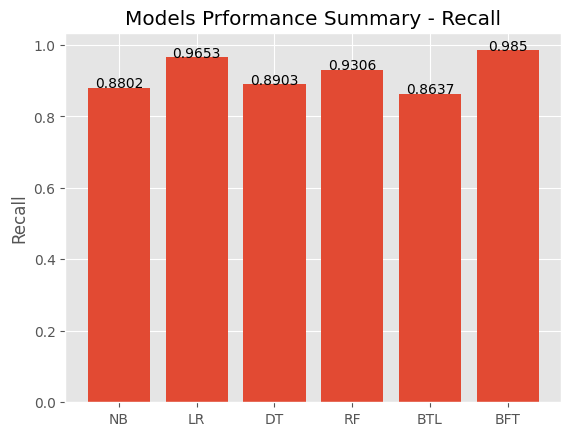

In [ ]:
#draw recall results graph
draw_results_graph(results_array_result_recall,
                   'Recall',
                   'Models Prformance Summary - Recall')

In terms of recall BFT has outperformed all models, followed by Logistic Regression. BTL has underperformed traditional models.

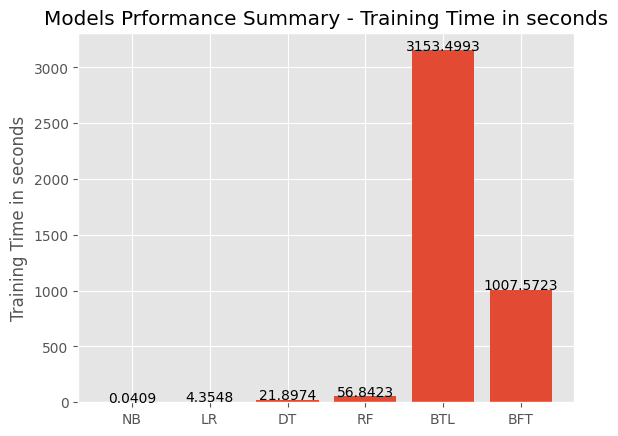

In [ ]:
#draw time to train results graph
draw_results_graph(results_array_execution_time,
                   'Training Time in seconds',
                   'Models Prformance Summary - Training Time in seconds')

Note: NB, LR, DT, RF are trained on CPU where as BTL, BFT are trained on GPU.

In terms of the training time there is a clear difference visible between the traditional models and the BERT based models.

BFT takes less time to train and has outperformed BTL

LR has a very good ratio of time it takes to train to performance

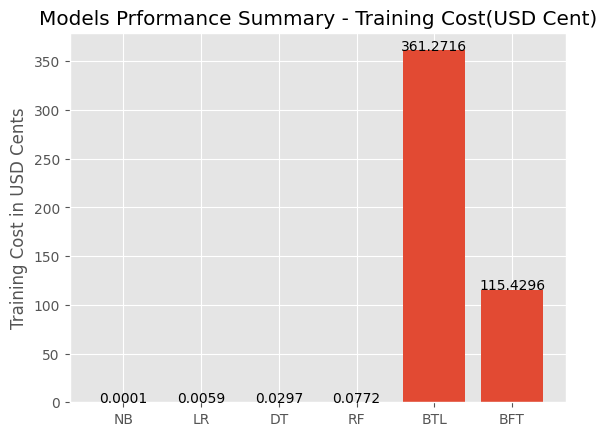

In [ ]:
#draw cost to train results graph
draw_results_graph(results_array_modeltrainingcost,
                   'Training Cost in USD Cents',
                   'Models Prformance Summary - Training Cost(USD Cent)')

Note: NB, LR, DT, RF are trained on CPU where as BTL, BFT are trained on GPU.

In terms of the training cost (accounted for GPU vs CPU cost) the traditional models are the cheapest. BTL is the most expensive and underperfors in terms of accuracy. BFT is the outperformer in accuracy and other performance metrics but costs more to train than the traditional models, but less than the BTL model.

####6.3 Confusion Matrices Results

Show traditional models confusion matrices

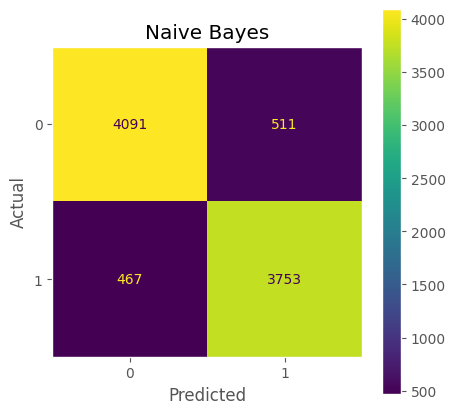

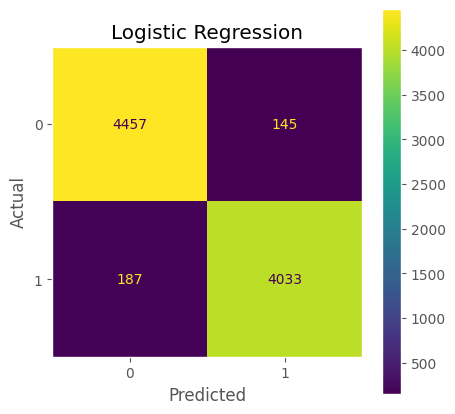

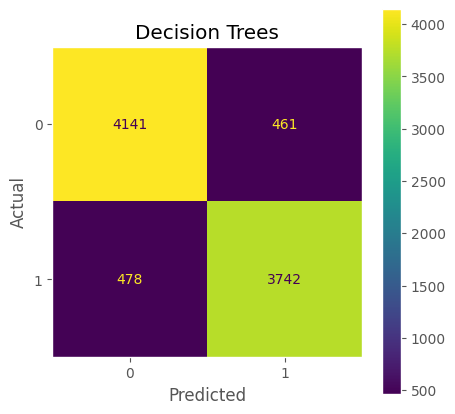

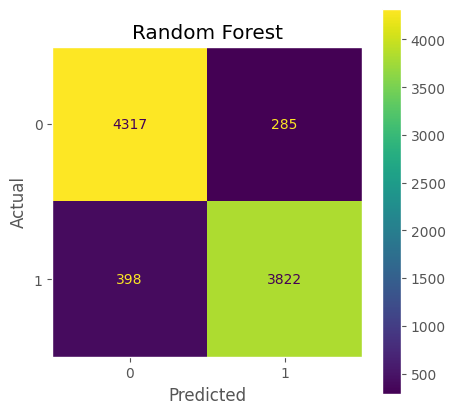

In [ ]:
#plot matrices
draw_results_cf('Naive Bayes', solved_NB_model, y_test_trad)
draw_results_cf('Logistic Regression', solved_tunded_LR_model, y_test_trad)
draw_results_cf('Decision Trees', solved_tunded_DT_model, y_test_trad)
draw_results_cf('Random Forest', solved_tunded_RF_model, y_test_trad)

Show BERT based models confusion matrices

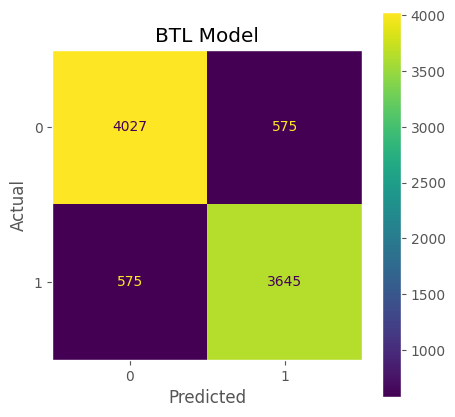

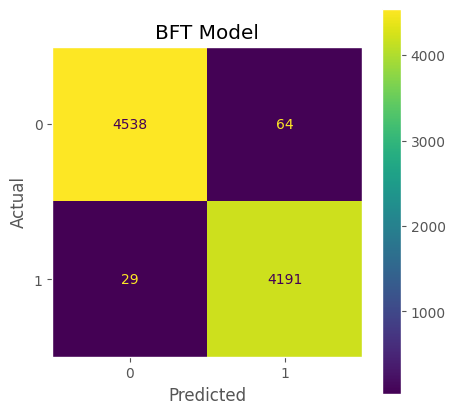

In [ ]:
#plot matrices
draw_results_cf('BTL Model', solved_tunded_BTL_model, y_test)
draw_results_cf('BFT Model', solved_tunded_BFT_model, y_test)